# VSS Summer School
## Self-supervised contrastive learning with SimCLR

In this lab, we will explore the implementation of SimCLR, a method for self-supervised pretraining of networks.

We will perform our pretraining on CIFAR10, a dataset of natural images, and then fine tune our network on SVHN, a dataset of pictures of house numbers.

You can find the original paper here: A Simple Framework for Contrastive Learning of Visual Representations (https://arxiv.org/abs/2002.05709)



First off, lets define the training and validation loops for normal, supervised classification.

In [1]:
import sys

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    model.train()

    total_train_loss = 0.0
    dataset_size = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_train_loss / dataset_size, 2)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)


    return epoch_loss

def valid_epoch(model, dataloader, device, criterion, epoch):
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    correct = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels).sum().item()

        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_val_loss / dataset_size, 2)

        accuracy = np.round(100 * correct / dataset_size, 2)

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    return accuracy, epoch_loss

def run_training(model, trainloader, testloader, criterion, optimizer, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    top_accuracy = 0.0

    for epoch in range(num_epochs):

        train_loss = train_epoch(model, trainloader, device, optimizer, criterion, epoch)
        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, testloader, device, criterion, epoch)
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy} ---> {val_accuracy})")
                top_accuracy = val_accuracy
        print()

In [3]:
# TODO - Add more transforms that act as image augmentations
# Remember that Self-Supervised methods benefit greatly from "heavier" data augmentations
# Checkout https://pytorch.org/vision/0.9/transforms.html
# Or search on google for a SimCLR implementation and copy their transforms from there

# Add horizontal flips, random resized crops, color jitter, grayscale etc.
# transforms.RandomHorizontalFlip( ... )
# transforms.RandomResizedCrop(... ) # images should remain at 32x32
# transforms.RandomRotation(...)
# transforms.ColorJitter(...)
# transforms.RandomGrayscale(...)


transform = transforms.Compose([
    # ...
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Define SVHN dataset (the final, downstream one)
svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Let's just use 10% of the data to make it harder
from collections import defaultdict
indices_per_class = defaultdict(list)
for i in range(len(svhn_trainset)):
  _, class_label = svhn_trainset[i]
  indices_per_class[class_label].append(i)

final_indices = []
for class_name, indices in indices_per_class.items():
  sampled_indices = indices[:int(0.1 * len(indices))]
  final_indices.extend(sampled_indices)

svhn_trainset = torch.utils.data.Subset(dataset = svhn_trainset, indices = final_indices)

svhn_trainloader = DataLoader(svhn_trainset, batch_size=256, shuffle=True)
svhn_testloader = DataLoader(svhn_testset, batch_size=256, shuffle=False)


100%|██████████| 170498071/170498071 [00:11<00:00, 14925413.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 182040794/182040794 [00:11<00:00, 15875963.53it/s]


100%|██████████| 64275384/64275384 [00:06<00:00, 10692689.80it/s]


     car    horse     deer      car    truck      car     frog      car


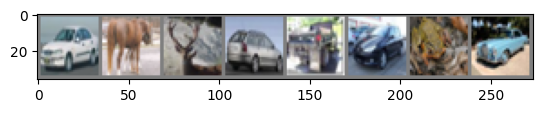

SVHN
       2        1        5        5        2        3        8        8


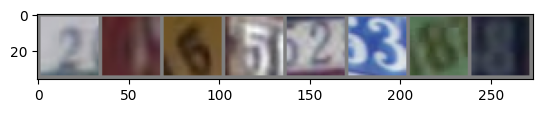

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


cifar_trainloader = DataLoader(cifar_trainset, batch_size=256, shuffle=True)
# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))
plt.show()

print('SVHN')

dataiter = iter(svhn_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join('%8s' % labels[j].item() for j in range(8)))
plt.show()


In [5]:
learning_rate = 0.001
epochs = 5

model = torchvision.models.resnet18(pretrained = False) # let's initialize a ResNet18 from scratch and pretrain it ourselves
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10, bias=True)

model.to(device)
criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Baseline result: Training a ResNet-18 from scratch on SVHN.

In [6]:
run_training(model, svhn_trainloader, svhn_testloader, criterion = criterion, optimizer = optimizer, num_epochs = epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 102/102 [00:09<00:00, 10.28it/s, Epoch=0, Valid_Acc=43.8, Valid_Loss=1.65]
Validation Accuracy Improved (0.0 ---> 43.75)

100%|██████████| 102/102 [00:10<00:00, 10.19it/s, Epoch=1, Valid_Acc=65, Valid_Loss=1.2]
Validation Accuracy Improved (43.75 ---> 65.02)

100%|██████████| 102/102 [00:09<00:00, 10.32it/s, Epoch=2, Valid_Acc=74.8, Valid_Loss=0.83]
Validation Accuracy Improved (65.02 ---> 74.84)

100%|██████████| 102/102 [00:09<00:00, 10.71it/s, Epoch=3, Valid_Acc=76.9, Valid_Loss=0.8]
Validation Accuracy Improved (74.84 ---> 76.94)

100%|██████████| 102/102 [00:09<00:00, 11.13it/s, Epoch=4, Valid_Acc=75, Valid_Loss=0.87]



## Baseline SVHN result is ... okish?

Can we do better?

YES!

Let's pretrain on CIFAR10 using SimCLR. First, let's define the SimCLR loss (contrastive loss).

Details are not important now. You can read the paper if you want to learn more.

In [7]:
class SimCLRLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()

        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

# helper stuff
def plot_features(model, dataloader, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for i, (x1,x2) in enumerate(dataloader):
            x1 = x1.squeeze().to(device = device, dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()
            feats = np.append(feats, out, axis = 0)

            if i == 100:
              break

    tsne = TSNE(n_components = 2, perplexity = 50, verbose = 2)
    x_feats = tsne.fit_transform(feats)

    plt.scatter(x_feats[:, 1], x_feats[:, 0])
    plt.show()

Custom model wrapper to have a projection head.

In [8]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class ModelForPretraining(nn.Module):
    def __init__(self, projector_size):
        super().__init__()

        self.pretrained = torchvision.models.resnet18(pretrained=False)

        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        self.pretrained.fc = Identity()

        for p in self.pretrained.parameters():
            p.requires_grad = True

        # TODO probably needs some adjusting, maybe it's too small?
        self.projector = nn.Linear(512, projector_size, bias = True)

    def forward(self,x):
        out = self.pretrained(x)
        xp = self.projector(torch.squeeze(out))
        return xp

class ModelForFinetuning(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()

        self.premodel = pretrained_model
        self.num_classes = 10

        # Freeze the layers of the pretrained model

        # TODO Optionally freeze model parameters if you have a good model and train only the last layer
        for p in self.premodel.parameters():
            p.requires_grad = False

        for p in self.premodel.projector.parameters():
            p.requires_grad = False

        # Fine-tune only the last layer
        self.lastlayer = nn.Linear(512, self.num_classes)

    def forward(self,x):
        out = self.premodel.pretrained(x)
        out = self.lastlayer(out)
        return out

# SimCLR training loop
## Augment an image two ways and compute the contrastive loss with respect to the other images in the batch

In [9]:
class TwoViewsDataset(torch.utils.data.Dataset):
  def __init__(self, source_dataset):
    # WARNING !!!! This assumes the dataset outputs augmented images
    self.source_dataset = source_dataset

  def __len__(self):
    return len(self.source_dataset)

  def __getitem__(self, idx):
    # each time is a different augmentation of the same image
    view1, _ = self.source_dataset[idx]
    view2, _ = self.source_dataset[idx]

    return view1, view2

In [10]:
cifar_trainloader = DataLoader(TwoViewsDataset(source_dataset = cifar_trainset), batch_size=128, shuffle=True, drop_last = True)
cifar_testloader = DataLoader(TwoViewsDataset(source_dataset = cifar_testset), batch_size=128, shuffle=True, drop_last = True)


# Usually train for a longer time
epochs = 5

model_for_pretraining = ModelForPretraining(projector_size = 256) # TODO might need some changes to the projector_size? Check the paper.
model_for_pretraining.to(device)

criterion = SimCLRLoss(batch_size = 128, temperature = 1.0) # TODO temperature might need some changes. Check the paper.
optimizer = optim.Adam(model_for_pretraining.parameters(), lr=learning_rate)

for epoch in range(epochs):
    print(f"Epoch [{epoch}/{epochs}]\t")
    model_for_pretraining.train()

    for step, (x_i, x_j) in enumerate(tqdm(cifar_trainloader, total = len(cifar_trainloader))):
        optimizer.zero_grad()

        x_i = x_i.squeeze().to(device).float()
        x_j = x_j.squeeze().to(device).float()

        # positive pair, with encoding
        z_i = model_for_pretraining(x_i)
        z_j = model_for_pretraining(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        if step % 25 == 0:
            print(f"Step [{step}/{len(cifar_trainloader)}]\t Train Loss: {round(loss.item(), 5)}")

    model_for_pretraining.eval()

    # Evaluation
    with torch.no_grad():
        val_loss_epoch = 0
        for step, (x_i, x_j) in enumerate(tqdm(cifar_testloader, total = len(cifar_testloader))):

          x_i = x_i.squeeze().to(device).float()
          x_j = x_j.squeeze().to(device).float()

          # positive pair, with encoding
          z_i = model_for_pretraining(x_i)
          z_j = model_for_pretraining(x_j)

          loss = criterion(z_i, z_j)

          if step % 25 == 0:
              print(f"Step [{step}/{len(cifar_testloader)}]\t Val Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    print(f"Epoch [{epoch}/{epochs}]")
    # TODO uncomment this to visualize clustering after each epoch. But it takes some time.
    # plot_features(model_for_pretraining.pretrained, cifar_testloader, 512, 128)


Epoch [0/5]	


  1%|          | 2/390 [00:00<01:57,  3.29it/s]

Step [0/390]	 Train Loss: 5.44982


  7%|▋         | 27/390 [00:06<01:22,  4.40it/s]

Step [25/390]	 Train Loss: 4.62459


 13%|█▎        | 52/390 [00:11<01:16,  4.42it/s]

Step [50/390]	 Train Loss: 4.59876


 20%|█▉        | 77/390 [00:17<01:11,  4.39it/s]

Step [75/390]	 Train Loss: 4.58446


 26%|██▌       | 102/390 [00:22<01:06,  4.33it/s]

Step [100/390]	 Train Loss: 4.57579


 33%|███▎      | 127/390 [00:28<01:00,  4.35it/s]

Step [125/390]	 Train Loss: 4.57191


 39%|███▉      | 152/390 [00:34<00:54,  4.34it/s]

Step [150/390]	 Train Loss: 4.56552


 45%|████▌     | 177/390 [00:39<00:49,  4.33it/s]

Step [175/390]	 Train Loss: 4.56307


 52%|█████▏    | 202/390 [00:45<00:43,  4.29it/s]

Step [200/390]	 Train Loss: 4.56151


 58%|█████▊    | 227/390 [00:51<00:38,  4.27it/s]

Step [225/390]	 Train Loss: 4.56093


 65%|██████▍   | 252/390 [00:56<00:32,  4.29it/s]

Step [250/390]	 Train Loss: 4.55868


 71%|███████   | 277/390 [01:02<00:27,  4.08it/s]

Step [275/390]	 Train Loss: 4.55825


 77%|███████▋  | 302/390 [01:08<00:20,  4.24it/s]

Step [300/390]	 Train Loss: 4.55587


 84%|████████▍ | 327/390 [01:14<00:15,  4.09it/s]

Step [325/390]	 Train Loss: 4.55584


 90%|█████████ | 352/390 [01:19<00:08,  4.25it/s]

Step [350/390]	 Train Loss: 4.55532


 97%|█████████▋| 377/390 [01:25<00:03,  4.12it/s]

Step [375/390]	 Train Loss: 4.55444


  3%|▎         | 2/78 [00:00<00:12,  6.21it/s]

Step [0/78]	 Val Loss: 4.57596


 35%|███▍      | 27/78 [00:03<00:06,  7.58it/s]

Step [25/78]	 Val Loss: 4.57154


 67%|██████▋   | 52/78 [00:06<00:03,  7.32it/s]

Step [50/78]	 Val Loss: 4.57143


 99%|█████████▊| 77/78 [00:10<00:00,  5.97it/s]

Step [75/78]	 Val Loss: 4.57218


100%|██████████| 78/78 [00:10<00:00,  7.24it/s]


Epoch [0/5]
Epoch [1/5]	


  1%|          | 2/390 [00:00<01:19,  4.86it/s]

Step [0/390]	 Train Loss: 4.55397


  7%|▋         | 27/390 [00:06<01:24,  4.31it/s]

Step [25/390]	 Train Loss: 4.5541


 13%|█▎        | 52/390 [00:11<01:23,  4.07it/s]

Step [50/390]	 Train Loss: 4.55265


 20%|█▉        | 77/390 [00:17<01:12,  4.29it/s]

Step [75/390]	 Train Loss: 4.55327


 26%|██▌       | 102/390 [00:23<01:10,  4.09it/s]

Step [100/390]	 Train Loss: 4.5527


 33%|███▎      | 127/390 [00:28<01:01,  4.28it/s]

Step [125/390]	 Train Loss: 4.55229


 39%|███▉      | 152/390 [00:34<00:58,  4.04it/s]

Step [150/390]	 Train Loss: 4.55179


 45%|████▌     | 177/390 [00:40<00:49,  4.28it/s]

Step [175/390]	 Train Loss: 4.55112


 52%|█████▏    | 202/390 [00:46<00:44,  4.26it/s]

Step [200/390]	 Train Loss: 4.55152


 58%|█████▊    | 227/390 [00:51<00:38,  4.28it/s]

Step [225/390]	 Train Loss: 4.55179


 65%|██████▍   | 252/390 [00:57<00:32,  4.30it/s]

Step [250/390]	 Train Loss: 4.55095


 71%|███████   | 277/390 [01:03<00:26,  4.25it/s]

Step [275/390]	 Train Loss: 4.55074


 77%|███████▋  | 302/390 [01:09<00:20,  4.30it/s]

Step [300/390]	 Train Loss: 4.55011


 84%|████████▍ | 327/390 [01:14<00:14,  4.27it/s]

Step [325/390]	 Train Loss: 4.54951


 90%|█████████ | 352/390 [01:20<00:08,  4.29it/s]

Step [350/390]	 Train Loss: 4.5504


 97%|█████████▋| 377/390 [01:26<00:03,  4.27it/s]

Step [375/390]	 Train Loss: 4.54935


  3%|▎         | 2/78 [00:00<00:12,  6.32it/s]

Step [0/78]	 Val Loss: 4.56443


 35%|███▍      | 27/78 [00:03<00:06,  7.57it/s]

Step [25/78]	 Val Loss: 4.56377


 67%|██████▋   | 52/78 [00:07<00:04,  6.02it/s]

Step [50/78]	 Val Loss: 4.56607


 99%|█████████▊| 77/78 [00:10<00:00,  7.43it/s]

Step [75/78]	 Val Loss: 4.56365


100%|██████████| 78/78 [00:10<00:00,  7.12it/s]


Epoch [1/5]
Epoch [2/5]	


  1%|          | 2/390 [00:00<01:21,  4.78it/s]

Step [0/390]	 Train Loss: 4.54995


  7%|▋         | 27/390 [00:06<01:24,  4.28it/s]

Step [25/390]	 Train Loss: 4.54994


 13%|█▎        | 52/390 [00:11<01:18,  4.32it/s]

Step [50/390]	 Train Loss: 4.54937


 20%|█▉        | 77/390 [00:17<01:13,  4.28it/s]

Step [75/390]	 Train Loss: 4.54962


 26%|██▌       | 102/390 [00:23<01:07,  4.27it/s]

Step [100/390]	 Train Loss: 4.54866


 33%|███▎      | 127/390 [00:29<01:01,  4.27it/s]

Step [125/390]	 Train Loss: 4.54863


 39%|███▉      | 152/390 [00:34<00:55,  4.26it/s]

Step [150/390]	 Train Loss: 4.54957


 45%|████▌     | 177/390 [00:40<00:49,  4.26it/s]

Step [175/390]	 Train Loss: 4.54861


 52%|█████▏    | 202/390 [00:46<00:44,  4.27it/s]

Step [200/390]	 Train Loss: 4.54811


 58%|█████▊    | 227/390 [00:51<00:37,  4.29it/s]

Step [225/390]	 Train Loss: 4.54908


 65%|██████▍   | 252/390 [00:57<00:33,  4.08it/s]

Step [250/390]	 Train Loss: 4.54916


 71%|███████   | 277/390 [01:03<00:26,  4.24it/s]

Step [275/390]	 Train Loss: 4.5484


 77%|███████▋  | 302/390 [01:09<00:21,  4.13it/s]

Step [300/390]	 Train Loss: 4.54829


 84%|████████▍ | 327/390 [01:14<00:14,  4.29it/s]

Step [325/390]	 Train Loss: 4.54817


 90%|█████████ | 352/390 [01:20<00:09,  4.04it/s]

Step [350/390]	 Train Loss: 4.54864


 97%|█████████▋| 377/390 [01:26<00:03,  4.32it/s]

Step [375/390]	 Train Loss: 4.54799


  3%|▎         | 2/78 [00:00<00:12,  6.17it/s]

Step [0/78]	 Val Loss: 4.56503


 35%|███▍      | 27/78 [00:03<00:08,  6.12it/s]

Step [25/78]	 Val Loss: 4.55868


 67%|██████▋   | 52/78 [00:07<00:03,  7.37it/s]

Step [50/78]	 Val Loss: 4.56079


 99%|█████████▊| 77/78 [00:11<00:00,  7.27it/s]

Step [75/78]	 Val Loss: 4.56073


100%|██████████| 78/78 [00:11<00:00,  6.99it/s]


Epoch [2/5]
Epoch [3/5]	


  1%|          | 2/390 [00:00<01:22,  4.72it/s]

Step [0/390]	 Train Loss: 4.54851


  7%|▋         | 26/390 [00:06<01:37,  3.71it/s]

Step [25/390]	 Train Loss: 4.54812


 13%|█▎        | 52/390 [00:11<01:18,  4.30it/s]

Step [50/390]	 Train Loss: 4.54791


 20%|█▉        | 77/390 [00:17<01:16,  4.11it/s]

Step [75/390]	 Train Loss: 4.54832


 26%|██▌       | 102/390 [00:23<01:07,  4.24it/s]

Step [100/390]	 Train Loss: 4.54804


 33%|███▎      | 127/390 [00:29<01:04,  4.08it/s]

Step [125/390]	 Train Loss: 4.54771


 39%|███▉      | 152/390 [00:34<00:55,  4.29it/s]

Step [150/390]	 Train Loss: 4.54752


 45%|████▌     | 177/390 [00:40<00:49,  4.27it/s]

Step [175/390]	 Train Loss: 4.54775


 52%|█████▏    | 202/390 [00:46<00:43,  4.28it/s]

Step [200/390]	 Train Loss: 4.54771


 58%|█████▊    | 227/390 [00:52<00:38,  4.21it/s]

Step [225/390]	 Train Loss: 4.54725


 65%|██████▍   | 252/390 [00:57<00:32,  4.26it/s]

Step [250/390]	 Train Loss: 4.54747


 71%|███████   | 277/390 [01:03<00:26,  4.22it/s]

Step [275/390]	 Train Loss: 4.54733


 77%|███████▋  | 302/390 [01:09<00:20,  4.28it/s]

Step [300/390]	 Train Loss: 4.5474


 84%|████████▍ | 327/390 [01:14<00:14,  4.28it/s]

Step [325/390]	 Train Loss: 4.54745


 90%|█████████ | 352/390 [01:20<00:08,  4.29it/s]

Step [350/390]	 Train Loss: 4.54743


 97%|█████████▋| 377/390 [01:26<00:03,  4.25it/s]

Step [375/390]	 Train Loss: 4.54719


  3%|▎         | 2/78 [00:00<00:12,  6.10it/s]

Step [0/78]	 Val Loss: 4.56149


 35%|███▍      | 27/78 [00:04<00:06,  7.31it/s]

Step [25/78]	 Val Loss: 4.56077


 67%|██████▋   | 52/78 [00:07<00:03,  6.53it/s]

Step [50/78]	 Val Loss: 4.56307


 99%|█████████▊| 77/78 [00:11<00:00,  7.11it/s]

Step [75/78]	 Val Loss: 4.56162


100%|██████████| 78/78 [00:11<00:00,  6.87it/s]


Epoch [3/5]
Epoch [4/5]	


  1%|          | 2/390 [00:00<01:21,  4.74it/s]

Step [0/390]	 Train Loss: 4.54717


  7%|▋         | 27/390 [00:06<01:24,  4.28it/s]

Step [25/390]	 Train Loss: 4.54728


 13%|█▎        | 52/390 [00:11<01:18,  4.29it/s]

Step [50/390]	 Train Loss: 4.54686


 20%|█▉        | 77/390 [00:17<01:13,  4.28it/s]

Step [75/390]	 Train Loss: 4.54765


 26%|██▌       | 102/390 [00:23<01:07,  4.27it/s]

Step [100/390]	 Train Loss: 4.54738


 33%|███▎      | 127/390 [00:29<01:01,  4.29it/s]

Step [125/390]	 Train Loss: 4.54687


 39%|███▉      | 152/390 [00:34<00:55,  4.28it/s]

Step [150/390]	 Train Loss: 4.54649


 45%|████▌     | 177/390 [00:40<00:49,  4.29it/s]

Step [175/390]	 Train Loss: 4.54667


 52%|█████▏    | 202/390 [00:46<00:44,  4.26it/s]

Step [200/390]	 Train Loss: 4.54673


 58%|█████▊    | 226/390 [00:51<00:44,  3.71it/s]

Step [225/390]	 Train Loss: 4.54676


 65%|██████▍   | 252/390 [00:57<00:32,  4.28it/s]

Step [250/390]	 Train Loss: 4.54668


 71%|███████   | 277/390 [01:03<00:27,  4.07it/s]

Step [275/390]	 Train Loss: 4.54654


 77%|███████▋  | 302/390 [01:09<00:20,  4.28it/s]

Step [300/390]	 Train Loss: 4.54688


 84%|████████▎ | 326/390 [01:14<00:17,  3.72it/s]

Step [325/390]	 Train Loss: 4.54712


 90%|█████████ | 352/390 [01:20<00:08,  4.25it/s]

Step [350/390]	 Train Loss: 4.54698


 97%|█████████▋| 377/390 [01:26<00:03,  4.28it/s]

Step [375/390]	 Train Loss: 4.54675


  3%|▎         | 2/78 [00:00<00:12,  6.11it/s]

Step [0/78]	 Val Loss: 4.55961


 35%|███▍      | 27/78 [00:03<00:06,  7.48it/s]

Step [25/78]	 Val Loss: 4.55733


 67%|██████▋   | 52/78 [00:07<00:03,  7.37it/s]

Step [50/78]	 Val Loss: 4.55868


 99%|█████████▊| 77/78 [00:10<00:00,  6.14it/s]

Step [75/78]	 Val Loss: 4.55797


100%|██████████| 78/78 [00:10<00:00,  7.20it/s]

Epoch [4/5]


## Model fine-tuning on 10% of SVHN

In [11]:
downstream_model = ModelForFinetuning(pretrained_model = model_for_pretraining)
downstream_model.to(device)

criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.Adam(downstream_model.parameters(), lr=0.001)

run_training(downstream_model, svhn_trainloader, svhn_testloader, criterion = criterion, optimizer = optimizer, num_epochs = epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 102/102 [00:14<00:00,  7.19it/s, Epoch=0, Valid_Acc=16.7, Valid_Loss=2.29]
Validation Accuracy Improved (0.0 ---> 16.67)

100%|██████████| 102/102 [00:14<00:00,  7.06it/s, Epoch=1, Valid_Acc=15.7, Valid_Loss=2.28]

100%|██████████| 102/102 [00:14<00:00,  7.22it/s, Epoch=2, Valid_Acc=17.5, Valid_Loss=2.27]
Validation Accuracy Improved (16.67 ---> 17.53)

100%|██████████| 102/102 [00:14<00:00,  7.06it/s, Epoch=3, Valid_Acc=17.4, Valid_Loss=2.28]

100%|██████████| 102/102 [00:14<00:00,  7.21it/s, Epoch=4, Valid_Acc=15.2, Valid_Loss=2.29]



## We have improved results!

#### If not, add more augmentations, pretrain for longer. Check the paper for more insights.